# Placement of products in retail stores
### Problem statement
<pre>
We would like you to implement a solution for product verification in retail stores. Specifically,
given a set of product spaces each containing some product images, write a solution to alarm a
store operator whether a product is kept in its correct product space or not. A product that doesn’t
belong to the correct product space is called a Plug
</pre>



### Data provided
<pre>
• embeddings.csv: contains embedding vectors [1280x1] of all product images.
• product_spaces.csv: contains product space info for each embedding vector.
• plug_labels.csv: contains plug label for each embedding vector.
The plug_label csv file contains binary labels. Label 0 means that the product belongs to the correct
product space and label 1 means that the product is a plug - the product doesn’t belong to the
correct product space.
</pre>


I have cleared the outputs of all cells to reduce the size of the file. Refer to this notebook if you are interested in the code, otherwise please refer to the blog, or the report. 

# Imports

In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import shutil
import os
import pandas as pd
import matplotlib
matplotlib.use(u'nbAgg')
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
import random as r
from sklearn.manifold import TSNE
from xgboost import XGBClassifier
import lightgbm as lgbm
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
import math
from pylab import rcParams

In [ ]:
# Mounting the drive in this environment
from google.colab import drive
drive.mount('/content/drive')

## Loading the data

In [ ]:
import pickle
X, Y = pickle.load(open('drive/My Drive/Retail Task/X_Y', 'rb'))
print("X.shape, Y.shape -> ", X.shape, Y.shape)
x_unb, y_unb = pickle.load(open('drive/My Drive/Retail Task/x_y_unb', 'rb'))
print("x_unb.shape, y_unb.shape -> ", x_unb.shape, y_unb.shape)
x_unb_cat, y_unb_cat = pickle.load(open('drive/My Drive/Retail Task/x_y_unb_cat', 'rb'))
print("x_unb_cat.shape, y_unb_cat.shape -> ", x_unb_cat.shape, y_unb_cat.shape)
X_cat, Y_cat = pickle.load(open('drive/My Drive/Retail Task/X_Y_cat', 'rb'))
print("X_cat.shape, Y_cat.shape -> ", X_cat.shape, Y_cat.shape)
x_train, y_train = pickle.load(open('drive/My Drive/Retail Task/x_y_train', 'rb'))
print("x_train.shape, y_train.shape -> ", x_train.shape, y_train.shape)
x_train_cat, y_train_cat = pickle.load(open('drive/My Drive/Retail Task/x_y_train_cat', 'rb'))
print("x_train_cat.shape, y_train_cat.shape -> ", x_train_cat.shape, y_train_cat.shape)
x_cv, y_cv = pickle.load(open('drive/My Drive/Retail Task/x_y_cv', 'rb'))
print("x_cv.shape, y_cv.shape -> ", x_cv.shape, y_cv.shape)
x_cv_cat, y_cv_cat = pickle.load(open('drive/My Drive/Retail Task/x_y_cv_cat', 'rb'))
print("x_cv_cat.shape, y_cv_cat.shape -> ", x_cv_cat.shape, y_cv_cat.shape)

# Metrics used: 
*   Two class log loss (binary cross-entropy) - 

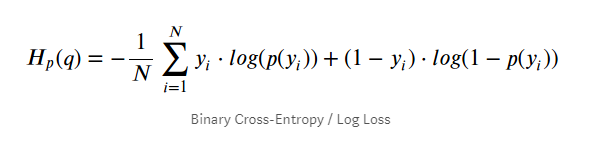
*   Accuracy score - Total number of correctly classified points over divided by the total numbe of points.
*   ROC_AUC score - Area under the reciever operating characteristic curve made with the probabilities of predicted classes.
*   F1 score - The harmonic mean of precision and recall.

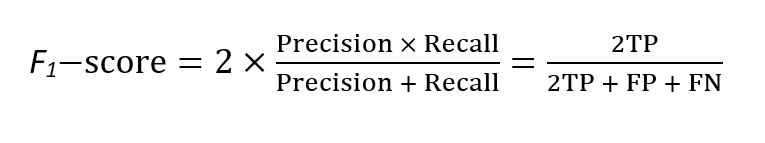
*   Confusion matrix - Display of True Positives, False Negatives, False Positives, and True Positives.

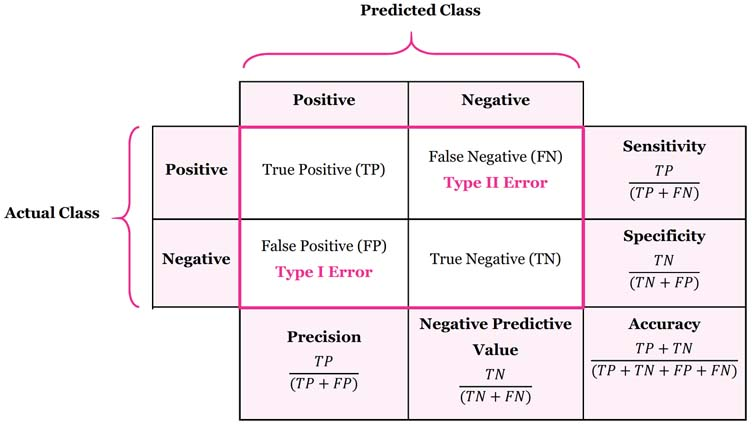

*   Precision (matrix) - Shows the precision for each of the elements in the confusion matrix. Precision is the fraction of points that actually belong to the class they have been classified into.
*   Recall (matrix) - Shows the recall for each of the elements in the confusion matrix. Recall is the fraction of points belonging to a particular class, that were correctly classified.

Please note that in our confusion matrix, the format is as shown below

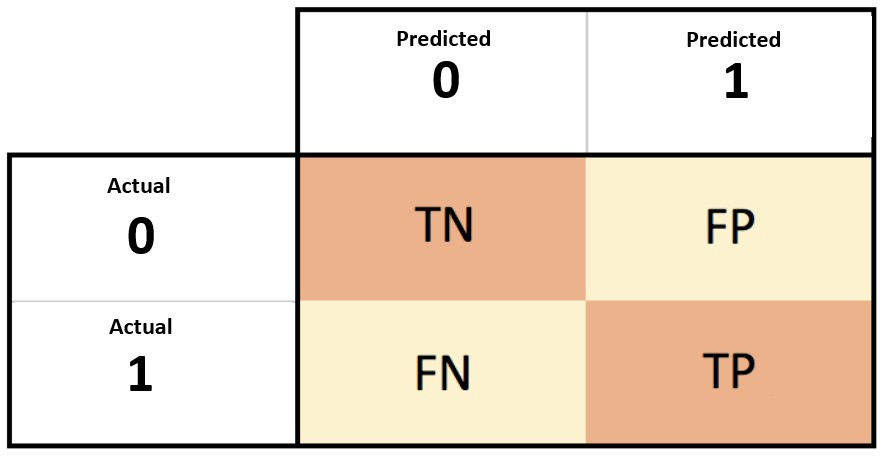

* Categorical cross-entropy (for the models with product spaces as labels)



In [ ]:
# The function we will use throughout to
# - plot the confusion matrix
# - precision matrix
# - recall matrix
# - print the percentage of misclassified points

def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # np.trace() gives the sum of all the diagonal elements which is the code given below gives us all the points that have been misclassified.
    print("Percentage of misclassified points ",(len(test_y)-np.trace(C))/len(test_y)*100)    # np.trace() gives the sum of all the diagonal elements
    # C = 2,2 matrix, each cell (i,j) represents number of points of class i are predicted class j
    # Hence, C corresponds to the confusion matix
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    # Hence, B corresponds to the precision matrix
    
    A =(((C.T)/(C.sum(axis=1))).T)
    # divide each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    # Hence, A corresponds to the recall matrix

    labels = [0,1]
    cmap=sns.light_palette("green")
    print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(6,3))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*50, "Precision matrix", "-"*50)
    # representing B in heatmap format
    plt.figure(figsize=(6,3))
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix",B.sum(axis=0))
    
    # representing A in heatmap format
    print("-"*50, "Recall matrix"    , "-"*50)
    plt.figure(figsize=(6,3))
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in recall matrix",A.sum(axis=1))

# Machine learning models 

### Baseline model
If we classify all products as non-plugs (majority) then the following are values we will get for various metrics:

In [ ]:
print("Accuracy: " + str(accuracy_score(y_unb, np.zeros(y_unb.shape))))
print("ROC-AUC: " + str(roc_auc_score(y_unb, np.zeros(y_unb.shape))))
print("F1 score: " + str(f1_score(y_unb, np.zeros(y_unb.shape))))

We should try and aim for an overall accuracy (and others) better than this. However, considering the fact that our main focus is to alert the retailer about all the plugs, false positives may be allowed, in order to increase the number of plugs detected and reduce the number of false negatives (positive being where there is a plug, in this context).

The general approach we will follow for testing various macchine learning models is as follows:

1) (Fitting model -> calibrated classifier -> calculating metrics) for all hyperparameter (hp) values in the hp range, 

2) Selecting the best value of hp and fitting the model with that value, 

3) Plotting the confusion matrices from the function above,
 
4) Interpreting results.

### Calibrated classifier
<pre>
This classifier is used on top of the basic classification model in order to generate probability values 
for each prediction instead of hard predictions. This will be required to calculate the two-class log-loss and roc_auc_score.
The two ways to perform this calibration is through 'sigmoidal' and 'isotonic' regression. We have mostly used the former.
</pre>
[sklearn.calibration.CalibratedClassifierCV](https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html)

In [ ]:
# Settin the figure size back to a smaller one
rcParams['figure.figsize'] = 6, 3

### Logistic Regression
<pre>
This is the first model one would test for binary classification to check whether the data is linearly separable or not. 
It is fast, and can handle high dimensionality data well. As discussed above, we will try various fits of this model 
(with varying regularization), both on 'cat_data' and 'ohe_data'.


In [ ]:
# default parameters
# sklearn.linear_model.LogisticRegression(penalty='l2', *, dual=False, tol=0.0001, C=1.0, fit_intercept=True, 
# intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='auto', 
# verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

# We are testing for all alpha values of the kind 10^i where i ranges from -5 to 3
alpha = [10 ** x for x in range(-4, 5)]
cv_log_error_array=[]   # array to store cross validation log losses
roc_score_array = []    # array to store cross validation roc_auc scores
for i in tqdm(alpha):
    logisticR=LogisticRegression(penalty='l2',C=i, class_weight = 'balanced')   # Initilizing the LR object with the approproate regularization paramter (C)
    logisticR.fit(x_train_cat,y_train_cat)
    sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
    sig_clf.fit(x_train_cat, y_train_cat)
    predict_y = sig_clf.predict_proba(x_cv_cat)
    cv_log_error_array.append(log_loss(y_cv_cat, predict_y, labels=logisticR.classes_, eps=1e-15))
    roc_score_array.append(roc_auc_score(y_cv_cat, predict_y[::, 1]))

# Printing the log-loss and roc_auc_score for all the fits
for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i], 'ROC-AUC score is: ', roc_score_array[i])

best_alpha = np.argmin(cv_log_error_array)

# Plotting the graph of log-loss for all the fits    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

logisticR=LogisticRegression(penalty='l2',C=alpha[best_alpha],class_weight='balanced')
logisticR.fit(x_train_cat,y_train_cat)
sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
sig_clf.fit(x_train_cat, y_train_cat)
pred_y=sig_clf.predict(x_unb_cat)

# Checking the value of log-loss for train, cv, and test sets with the best value of C
predict_y = sig_clf.predict_proba(x_train_cat)
print ('log loss for train data',log_loss(y_train_cat, predict_y, labels=logisticR.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(x_cv_cat)
print ('log loss for cv data',log_loss(y_cv_cat, predict_y, labels=logisticR.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(x_unb_cat)
print ('log loss for test data',log_loss(y_unb_cat, predict_y, labels=logisticR.classes_, eps=1e-15))
plot_confusion_matrix(y_unb_cat, sig_clf.predict(x_unb_cat))

Not bad.

The good news is that our approach may indeed work out. We are able to correctly detect ~60% plugs and only 4% of non-plugs are incorrectly classified. However, we still are getting a lot of False Positives and False Negatives.

Let us now try with 'ohe_data'.

In [ ]:
# default parameters
# sklearn.linear_model.LogisticRegression(penalty='l2', *, dual=False, tol=0.0001, C=1.0, fit_intercept=True, 
# intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='auto', 
# verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

# We are testing for all alpha values of the kind 10^i where i ranges from -5 to 3
alpha = [10 ** x for x in range(-5, 4)]
cv_log_error_array=[]   # array to store cross validation log losses
roc_score_array = []    # array to store cross validation roc_auc scores
for i in tqdm(alpha):
    logisticR=LogisticRegression(penalty='l2',C=i, class_weight = 'balanced')   # Initilizing the LR object with the approproate regularization paramter (C)
    logisticR.fit(x_train,y_train)
    sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
    sig_clf.fit(x_train, y_train)
    predict_y = sig_clf.predict_proba(x_cv)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=logisticR.classes_, eps=1e-15))
    roc_score_array.append(roc_auc_score(y_cv, predict_y[::, 1]))

# Printing the log-loss and roc_auc_score for all the fits
for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i], 'ROC-AUC score is: ', roc_score_array[i])

best_alpha = np.argmin(cv_log_error_array)

# Plotting the graph of log-loss for all the fits    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

logisticR=LogisticRegression(penalty='l2',C=alpha[best_alpha],class_weight='balanced')
logisticR.fit(x_train,y_train)
sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
sig_clf.fit(x_train, y_train)
pred_y=sig_clf.predict(x_unb)

predict_y = sig_clf.predict_proba(x_train)
print ('log loss for train data',log_loss(y_train, predict_y, labels=logisticR.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(x_cv)
print ('log loss for cv data',log_loss(y_cv, predict_y, labels=logisticR.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(x_unb)
print ('log loss for test data',log_loss(y_unb, predict_y, labels=logisticR.classes_, eps=1e-15))
plot_confusion_matrix(y_unb, sig_clf.predict(x_unb))

Much better!

The number of Falsely classified points has reduced on both sides. This in itself won't be too bad a solution. 

Let us now check other metrics for this model as well.

In [ ]:
%%time
logisticR=LogisticRegression(penalty='l2',C=10, class_weight = 'balanced')   # Initilizing the LR object with the approproate regularization paramter (C)
logisticR.fit(x_train,y_train)
sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
sig_clf.fit(x_train, y_train)
prob_y = sig_clf.predict_proba(x_unb)[:,1]

In [ ]:
%%time
predict_y = logisticR.predict(x_unb)
print(accuracy_score(y_unb, predict_y))
print(roc_auc_score(y_unb, prob_y))
print(f1_score(y_unb, predict_y))

In [ ]:
predict_y = logisticR.predict(x_unb)
plot_confusion_matrix(y_unb, predict_y)

The Recall is reasonably good but the Precision still has scope for improvement. We shall have to explore further models for this. We don't want the store employees making unnecessary rounds, do we?

### Naive Bayes
<pre>
Naive Bayes has been extensively used for text classification with a large number of features. 
We are trying two types of NB models to see if this problem can be successfully solved the same principles:
  1.   Multinomial Naive Bayes - even though this method is more suited for discrete distributions, 
       it does work adequately well in practice with tf-idf features as well. 
  2.   Gaussian Naive Bayes - This is meant for continuous distributions as it is, which is why we can 
       expect positive results.


#### Multinomial Naive Bayes

In [ ]:
# default parameters
# sklearn.naive_bayes.MultinomialNB(*, alpha=1.0, fit_prior=True, class_prior=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.
# predict_proba(X) Return probability estimates for the test vector X.

# We are testing for all alpha values of the kind 10^i where i ranges from -5 to 4
# Here alpha is the laplace smoothing parameter

alpha = [10 ** x for x in range(-5, 4)]
cv_log_error_array=[]   
roc_score_array = []    
for i in tqdm(alpha):
    nbc = MultinomialNB(alpha = i)   
    nbc.fit(x_train_cat,y_train_cat)
    sig_clf = CalibratedClassifierCV(nbc, method="sigmoid")
    sig_clf.fit(x_train_cat, y_train_cat)
    predict_y = sig_clf.predict_proba(x_cv_cat)
    cv_log_error_array.append(log_loss(y_cv_cat, predict_y, labels=nbc.classes_, eps=1e-15))
    roc_score_array.append(roc_auc_score(y_cv_cat, predict_y[::, 1]))

# Printing the log-loss and roc_auc_score for all the fits
for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i], 'ROC-AUC score is: ', roc_score_array[i])

# Getting the best alpha value based on log-loss
best_alpha = np.argmin(cv_log_error_array)

# Plotting the graph of log-loss for all the fits 
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

nbc = MultinomialNB(alpha = alpha[best_alpha])
nbc.fit(x_train_cat,y_train_cat)
sig_clf = CalibratedClassifierCV(nbc, method="sigmoid")
sig_clf.fit(x_train_cat, y_train_cat)
pred_y=sig_clf.predict(x_unb_cat)

# Comparing the train, cv, and test log-loss for the model with the best value of alpha
predict_y = sig_clf.predict_proba(x_train_cat)
print ('log loss for train data',log_loss(y_train_cat, predict_y, labels=nbc.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(x_cv_cat)
print ('log loss for cv data',log_loss(y_cv_cat, predict_y, labels=nbc.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(x_unb_cat)
print ('log loss for test data',log_loss(y_unb_cat, predict_y, labels=nbc.classes_, eps=1e-15))
plot_confusion_matrix(y_unb_cat, sig_clf.predict(x_unb_cat))

Seems like this did not work out as well as we had hoped. Both False Positives and False Negatives have increased as compared to the values Logistic Regression was producing. Let's try out 'ohe_data' and see if there is any improvement.


In [ ]:
# We are testing for all alpha values of the kind 10^i where i ranges from -5 to 4
alpha = [10 ** x for x in range(-5, 4)]
cv_log_error_array=[]   # array to store cross validation log losses
roc_score_array = []    # array to store cross validation roc_auc scores
for i in tqdm(alpha):
    nbc = MultinomialNB(alpha = i)   # Initilizing the NB object with the approproate smoothing paramter (alpha)
    nbc.fit(x_train,y_train)
    sig_clf = CalibratedClassifierCV(nbc, method="sigmoid")  
    sig_clf.fit(x_train, y_train)
    predict_y = sig_clf.predict_proba(x_cv)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=nbc.classes_, eps=1e-15))
    roc_score_array.append(roc_auc_score(y_cv, predict_y[::, 1]))

# Printing the log-loss and roc_auc_score for all the fits
for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i], 'ROC-AUC score is: ', roc_score_array[i])

# Plotting the graph of log-loss for all the fits 
best_alpha = np.argmin(cv_log_error_array)
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

nbc = MultinomialNB(alpha = alpha[best_alpha])
nbc.fit(x_train,y_train)
sig_clf = CalibratedClassifierCV(nbc, method="sigmoid")
sig_clf.fit(x_train, y_train)
pred_y=sig_clf.predict(x_unb)

# Comparing the train, cv, and test log-loss for the model with the best value of alpha
predict_y = sig_clf.predict_proba(x_train)
print ('log loss for train data',log_loss(y_train, predict_y, labels=nbc.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(x_cv)
print ('log loss for cv data',log_loss(y_cv, predict_y, labels=nbc.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(x_unb)
print ('log loss for test data',log_loss(y_unb, predict_y, labels=nbc.classes_, eps=1e-15))
plot_confusion_matrix(y_unb, sig_clf.predict(x_unb))

Considering the plugs, we can say there is a significant improvement after using 'ohe_data' instead of 'cat_data'. We have a decent plug detection rate but the False Positives are too many, hence the precision is very low.

In [ ]:
%%time
nbc = MultinomialNB(alpha = 0.01)   # Initilizing the LR object with the approproate regularization paramter (C)
nbc.fit(x_train,y_train)
sig_clf = CalibratedClassifierCV(nbc, method="isotonic")
sig_clf.fit(x_train, y_train)
prob_y = sig_clf.predict_proba(x_unb)[:,1]

In [ ]:
%%time
predict_y = nbc.predict(x_unb)
print(accuracy_score(y_unb, predict_y))
print(roc_auc_score(y_unb, prob_y))
print(f1_score(y_unb, predict_y))

In [ ]:
plot_confusion_matrix(y_unb, predict_y)

The number of False Negatives has decreased even more in this fit but the number of False Positives has increased. We may explore the possibility that there is a trade-off between the two values in this data.

#### Gaussian Naive Bayes

In [ ]:
%%time
nbc = GaussianNB(var_smoothing = 0.01)   # Initilizing the LR object with the approproate regularization paramter (C)
nbc.fit(x_train,y_train)
sig_clf = CalibratedClassifierCV(nbc, method="isotonic")
sig_clf.fit(x_train, y_train)
prob_y = sig_clf.predict_proba(x_unb)[:,1]

In [ ]:
%%time
predict_y = nbc.predict(x_unb)
print(accuracy_score(y_unb, predict_y))
print(roc_auc_score(y_unb, prob_y))
print(f1_score(y_unb, predict_y))

In [ ]:
plot_confusion_matrix(y_unb, predict_y)

Very interesting results:

1.   The Recall has improved even more, to a very impressive level (~0.96).
2.   The Precision has decreased even more, to a very troublesome level (~0.127).
3.   We can think of a strategy in which we use the fact that most of the plugs are detected by GNB, and somehow filter out the non-plugs to return a result with high values of both Precision and Recall.
4.   Both the Naive Bayes classifiers are extremely fast, which takes away the reservation against adding too many steps to the pipeline.

We shall have to explore further.


### Support Vector Machines (SVC)
<pre>
The SVC class is based on the libsvm library which implements the kernel feature. 
The given features will be mapped to a much higher dimensional space for training.
As this is a medium sized dataset with many features, this classifier is an appropriate choice.
It also handles sparse features well. As we have seen better performance for 'ohe_data' in both previous models, 
we will use only that data from now on.

In [ ]:
# default parameters
# sklearn.svm.SVC(*, C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, 
# class_weight=None, verbose=False, max_iter=-1, decision_function_shape='ovr', break_ties=False, random_state=None)
# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

# Here we are varying the L2 regularization parameter, C (alpha).
# Larger values of C correspond to lesser regularization.
alpha = [10 ** x for x in range(-1, 4)]
cv_log_error_array=[]
roc_score_array = []
for i in tqdm(alpha):
    svc = SVC(C = i, class_weight='balanced')
    svc.fit(x_train, y_train) 
    sig_clf = CalibratedClassifierCV(svc, method="sigmoid")
    sig_clf.fit(x_train, y_train)
    predict_y = sig_clf.predict_proba(x_cv)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=svc.classes_, eps=1e-15))
    roc_score_array.append(roc_auc_score(y_cv, predict_y[::, 1]))

# Printing the log-loss and roc_auc_score for all the fits
for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i], 'ROC-AUC score is: ', roc_score_array[i])

best_alpha = np.argmin(cv_log_error_array)
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

svc = SVC(C=alpha[best_alpha],class_weight='balanced')
svc.fit(x_train,y_train)
sig_clf = CalibratedClassifierCV(svc, method="sigmoid")
sig_clf.fit(x_train, y_train)

# Checking the value of log-loss for train, cv, and test sets with the best value of C
predict_y = sig_clf.predict_proba(x_train)
print ('log loss for train data',log_loss(y_train, predict_y, labels=svc.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(x_cv)
print ('log loss for cv data',log_loss(y_cv, predict_y, labels=svc.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(x_unb)
print ('log loss for test data',log_loss(y_unb, predict_y, labels=svc.classes_, eps=1e-15))
plot_confusion_matrix(y_unb, sig_clf.predict(x_unb))

The number of False Positves has reduced significantly, to as low as 6. However, we have missed more plugs as compared to the previous two models.

Let us check other metrics after fitting it again.

In [ ]:
%%time
svc = SVC(C = 1000, class_weight='balanced')
svc.fit(x_train, y_train) 
sig_clf = CalibratedClassifierCV(svc, method="sigmoid")
sig_clf.fit(x_train, y_train)

In [ ]:
%%time
predict_y = svc.predict(x_unb)
prob_y = sig_clf.predict_proba(x_unb)[:,1]
print(accuracy_score(y_unb, predict_y))
print(roc_auc_score(y_unb, prob_y))
print(f1_score(y_unb, predict_y))

In [ ]:
plot_confusion_matrix(y_unb, predict_y)

Very promising results. 

For the first time we are seeing something close to what is desired. 

On the other hand, the time taken for training and for prediction is significantly more than the previously used models. Still, a prediction time of 1 minute for ~2600 items is not too slow either. Depends on what the retailer wants.

In [ ]:
%%time
svc = SVC(C = 1, class_weight='balanced')
svc.fit(x_train, y_train) 
sig_clf = CalibratedClassifierCV(svc, method="sigmoid")
sig_clf.fit(x_train, y_train)

In [ ]:
%%time
predict_y = svc.predict(x_unb)
prob_y = sig_clf.predict_proba(x_unb)[:,1]
print(accuracy_score(y_unb, predict_y))
print(roc_auc_score(y_unb, prob_y))
print(f1_score(y_unb, predict_y))

In [ ]:
plot_confusion_matrix(y_unb, predict_y)

Fascinating.

Looks like our understanding of the trade-off between Precision and Recall might be correct. 

Again, if the retailer does not mind checking some extra items that aren't actually plugs, in order to miss less of them, this solution would be more suitable for them.

Let us explore further.

### K Nearest Neighbours
<pre>
This classifier fundamentally finds the closest 'n' neighbors of the query point using one of 
'ball_tree', 'kd_tree', and brute force search methods, in the vector space. 
KNN has been used at other places for learning the similarity between items using image feature embeddings. 
Our hope is that it will work here as well.

In [ ]:
# default parameters
# sklearn.neighbors.KNeighborsClassifier(n_neighbors=5, *, weights='uniform', algorithm='auto', leaf_size=30, p=2, 
# metric='minkowski', metric_params=None, n_jobs=None, **kwargs)
# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

K = [1, 3, 5, 7, 10, 15]
cv_log_error_array=[]
roc_score_array = []
for i in tqdm(K):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(x_train, y_train) 
    sig_clf = CalibratedClassifierCV(knn, method="sigmoid")
    sig_clf.fit(x_train, y_train)
    predict_y = sig_clf.predict_proba(x_cv)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=knn.classes_, eps=1e-15))
    roc_score_array.append(roc_auc_score(y_cv, predict_y[::, 1]))

# Printing the log-loss and roc_auc_score for all the fits
for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',K[i],'is',cv_log_error_array[i], 'ROC-AUC score is: ', roc_score_array[i])

best_k = np.argmin(cv_log_error_array)
    
fig, ax = plt.subplots()
ax.plot(K, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((K[i],np.round(txt,3)), (K[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

knn = KNeighborsClassifier(n_neighbors = K[best_k])
knn.fit(x_train,y_train)
sig_clf = CalibratedClassifierCV(knn, method="sigmoid")
sig_clf.fit(x_train, y_train)

# Checking the value of log-loss for train, cv, and test sets with the best value of K
predict_y = sig_clf.predict_proba(x_train)
print ('log loss for train data',log_loss(y_train, predict_y, labels=knn.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(x_cv)
print ('log loss for cv data',log_loss(y_cv, predict_y, labels=knn.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(x_unb)
print ('log loss for test data',log_loss(y_unb, predict_y, labels=knn.classes_, eps=1e-15))
plot_confusion_matrix(y_unb, sig_clf.predict(x_unb))

Overall, these seem to be the best results so far.

Out of 2602 points only 22/94 plugs were missed and only 30/2508 non-plugs were classified as plugs.

One more important thing to note is that we are getting the best results with n_neighbours(K) = 1. This means that items most similar to the query items are the best indicators of the query item being a plug or not.

Just to experiment, let us see if the number of plugs missed reduces if we change K to 3 and used weighted distance.

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(x_train, y_train) 
sig_clf = CalibratedClassifierCV(knn, method="sigmoid")
sig_clf.fit(x_train, y_train)

In [ ]:
%%time
predict_y_knn = sig_clf.predict(x_unb)
prob_y_knn = sig_clf.predict_proba(x_unb)[:,1]
print(accuracy_score(y_unb, predict_y_knn))
print(roc_auc_score(y_unb, prob_y_knn))
print(f1_score(y_unb, predict_y_knn))

In [ ]:
plot_confusion_matrix(y_unb, predict_y_knn)

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 5, weights = 'distance')
knn.fit(x_train, y_train) 
sig_clf = CalibratedClassifierCV(knn, method="sigmoid")
sig_clf.fit(x_train, y_train)

In [ ]:
%%time
predict_y = sig_clf.predict(x_unb)
prob_y = sig_clf.predict_proba(x_unb)[:,1]
print(accuracy_score(y_unb, predict_y))
print(roc_auc_score(y_unb, prob_y))
print(f1_score(y_unb, predict_y))

In [ ]:
plot_confusion_matrix(y_unb, predict_y)

Looks like the performance is best with K = 1 only.

The major drawback of this approach is the time taken during prediction. KNN takes ~ 0 training time but the prediction time is significantly large. The retailer would have to decide whether this is alright (add exact time).

### Random Forest 
<pre>
This is one of the most advanced machine learning models that handles all kinds of features well. 
Random sampling ensures less susceptibility to overfitting. 
Once trained, these models can yield predictions very fast as it simply involves checking of some if else conditions.

In [ ]:
# default parameters 
# sklearn.ensemble.RandomForestClassifier(n_estimators=10, criterion=’gini’, max_depth=None, min_samples_split=2, 
# min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
# min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, 
# class_weight=None)

# Some of methods of RandomForestClassifier()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# predict_proba (X)	Perform classification on samples in X.

# some of attributes of  RandomForestClassifier()
# feature_importances_ : array of shape = [n_features]
# The feature importances (the higher, the more important the feature).

alpha=[50,100,500,1000]
cv_log_error_array=[]
train_log_error_array=[]
roc_score_array = []
for i in tqdm(alpha):
    r_cfl=RandomForestClassifier(n_estimators=i,random_state=42,n_jobs=-1)
    r_cfl.fit(x_train,y_train)
    sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
    sig_clf.fit(x_train, y_train)
    predict_y = sig_clf.predict_proba(x_cv)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=r_cfl.classes_, eps=1e-15))
    roc_score_array.append(roc_auc_score(y_cv, predict_y[::, 1]))

# Printing the log-loss and roc_auc_score for all the fits
for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i], 'ROC-AUC score is: ', roc_score_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


r_cfl=RandomForestClassifier(n_estimators=alpha[best_alpha],random_state=42,n_jobs=-1)
r_cfl.fit(x_train,y_train)
sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
sig_clf.fit(x_train, y_train)

# Checking the value of log-loss for train, cv, and test sets with the best value of n_estimators
predict_y = sig_clf.predict_proba(x_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(x_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(x_unb)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_unb, predict_y))
plot_confusion_matrix(y_unb, sig_clf.predict(x_unb))

These results are dissapointing. Although, there are absolutely no False Positives, a majority of plugs are getting missed. This kind of a model would not help our case.

Just to make sure that this performance is not due to lack of training, let us train the model with 500 learners instead of a 100.

In [ ]:
r_cfl=RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1)
r_cfl.fit(x_train,y_train)
sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
sig_clf.fit(x_train, y_train)

In [ ]:
%%time
prob_y = sig_clf.predict_proba(x_unb)[:,1]
pred_y = sig_clf.predict(x_unb)
print(accuracy_score(y_unb, pred_y))
print(roc_auc_score(y_unb, prob_y))
print(f1_score(y_unb, pred_y))

In [ ]:
plot_confusion_matrix(y_unb, pred_y)

Clearly, there isn't much difference.

On the other hand, we can note that Random Forest is biased towards non-plugs. When we fitted Gaussian Naive Bayes on the same data, it captured almost all plugs and misclassified a lot of non-plugs. We can explore the idea of stacking these two models in the hope of balancing out both biases and getting a desirable result.

Before that, let us try some other tree-based models.

### Gradient Boosting
<pre>
Under this category, we will use the following 2 classifiers:
  1.   XGBoost (XGBClassifier) 
  2.   LightGBM (LGBMClassifier)
Both of these classifiers work on the same principle of sequentially improving models where a new models learns from the 
previous model's mistakes. 
They are often used with data having the order of features that we do and provide very strong results. 
Prediction is also fast with these models.


#### XGBoost
<pre>
First we will try and find the most suitable parameters using RandomizedSearchCV, 
as there are a lot of hyperparameters that can be tweaked.

In [ ]:
x_cfl=XGBClassifier()

prams={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[100,200,500],
     'max_depth':[3,5,10],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}
random_cfl=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,n_jobs=-1,)
random_cfl.fit(x_train,y_train)

In [ ]:
print(random_cfl.best_params_)

In [ ]:
x_cfl=XGBClassifier(n_estimators=100, subsample = 1, colsample_bytree=0.3, learning_rate=0.05, max_depth=10, nthread=-1)
x_cfl.fit(x_train,y_train)
sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
sig_clf.fit(x_train, y_train)

In [ ]:
%%time
predict_y = sig_clf.predict(x_unb)
prob_y = sig_clf.predict_proba(x_unb)[:,1]
print(accuracy_score(y_unb, predict_y))
print(roc_auc_score(y_unb, prob_y))
print(f1_score(y_unb, predict_y))

In [ ]:
plot_confusion_matrix(y_unb, predict_y)

This result is better than Random Forest but is still not as good as the models we have seen before. It seems like a trend in tree-based classifiers to be biased towards non-plugs, at least the way we are training them.

#### LightGBM
<pre>
Again, we will first find the best parameters of this model for this task.

In [ ]:
lg_cfl = lgbm.LGBMClassifier()
prams={
    'learning_rate':[0.05,0.1,0.15,0.2],
     'n_estimators':[500, 1000],
     'max_depth':[3,5,10],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.5,1]
}
randlg_cfl=RandomizedSearchCV(lg_cfl, n_iter = 10, param_distributions=prams,verbose=10,n_jobs=-1,)
randlg_cfl.fit(x_train, y_train)

In [ ]:
print(randlg_cfl.best_params_)

In [ ]:
lg_cfl=lgbm.LGBMClassifier(n_estimators=500,max_depth=10,learning_rate=0.05,colsample_bytree=0.5,subsample=1,nthread=-1, verbose = 50)
lg_cfl.fit(x_train, y_train)
sig_clf = CalibratedClassifierCV(lg_cfl, method="sigmoid")
sig_clf.fit(x_train, y_train)

In [ ]:
%%time
predict_y = sig_clf.predict(x_unb)
prob_y = sig_clf.predict_proba(x_unb)[:,1]
print(accuracy_score(y_unb, predict_y))
print(roc_auc_score(y_unb, prob_y))
print(f1_score(y_unb, predict_y))

In [ ]:
%matplotlib inline
plot_confusion_matrix(y_unb, predict_y)

This result is better than XGBoost but is still not the best we have seen. We will have to think of different approaches.

### Stacked Models
We will use the following combinations of models in the hope of getting better results.

1.   Gaussian Naive Bayes + Random Forest 
2.   Gaussian Naive Bayes + K Nearest Neighbors
3.   Gaussian Naive Bayes + Support Vector Machines
4.   Gaussian Naive Bayes + Deep Neural Network (Model 2)
5.   Gaussian Naive Bayes + Deep Neural Network (Model 3)

#### Gaussian Naive Bayes + Random Forest
<pre>
As discussed before, we have observed that GNB is biased towards plugs and RF is biased towards non-plugs.
In this stacked model, we will use GNB to predict plugs and will add the predictions as a feature to the original data.
This data will then be passed into a Random Forest classifier.
Our expectation is that the added feature would prevent the Random Forest Classifier from generating too many False Negatives.

In [ ]:
# Fitting GNB onto the training data
%%time
nbc = GaussianNB(var_smoothing=0.01)
nbc.fit(x_train, y_train)

In [ ]:
# Making predictions for the training data itself, to reaffirm our conclusion that the plugs will be correctly classified
%%time
pred_y = nbc.predict(x_train)
prob_y = nbc.predict_proba(x_train)[:,1]
print(accuracy_score(y_train, pred_y))
print(roc_auc_score(y_train, prob_y))
print(f1_score(y_train, pred_y))

In [ ]:
plot_confusion_matrix(y_train, pred_y)

It is clear that all the plugs are being correctly classified. We have a lot of false positves, which RF will hopefully take care of.

In [ ]:
# Taking note of all the indices in the prediction array that are predicted to be plugs
inds = []
for i, p in enumerate(pred_y):
  if p == 1:
    inds.append(i)
print(len(inds))
print(inds[:10])

The number given here matches the number of predicted plugs we can see in our confusion matrix.

In [ ]:
# Separating out the points that GNB predicted as plugs
# This data will be used later for a different stacked model
x_sep_train = x_train.iloc[inds, :]
y_sep_train = y_train.iloc[inds]
print(x_sep_train.shape, y_sep_train.shape)

In [ ]:
# Creating and adding the additional feature of GNB predictions to a copy of the original data
# 'x_nb' and 'y_nb' correspond to the new training data input and output
nb_plugs = np.zeros((len(x_train)))
for i in inds:
  nb_plugs[i] = 1
x_nb = x_train.copy()
x_nb['pred'] = nb_plugs
print(x_nb.shape)
y_nb = y_train.copy()
print(y_nb.shape)

In [ ]:
# Fitting the Random Forest Classifier on data containing the new feature
r_cfl = RandomForestClassifier(n_estimators=200)
r_cfl.fit(x_nb, y_nb)

In [ ]:
# Checking if the accuracy is good enough for the training data by evaluating various metrics on predictions made using training data
y_pred = r_cfl.predict(x_nb)
y_prob = r_cfl.predict_proba(x_nb)[:,1]
print(accuracy_score(y_nb, y_pred))
print(roc_auc_score(y_nb, y_prob))
print(f1_score(y_nb, y_pred))

Now, we will repeat this process for cv data

In [ ]:
# Taking note of all the indices in the prediction array that are predicted to be plugs, from cv data
y_pred_cv = nbc.predict(x_cv)
inds = []
for i, p in enumerate(y_pred_cv):
  if p == 1:
    inds.append(i)
print(len(inds))
print(inds[:10])

In [ ]:
# Separating out the points that GNB predicted as plugs
# This data will be used later for a different stacked model
x_sep_cv = x_cv.iloc[inds, :]
y_sep_cv = y_cv.iloc[inds]
print(x_sep_cv.shape, y_sep_cv.shape)

In [ ]:
# Creating and adding the additional feature of GNB predictions to a copy of the original data
# 'x_nb_cv' and 'y_nb_cv' correspond to the new cv data input and output
nb_plugs = np.zeros((len(x_cv)))
for i in inds:
  nb_plugs[i] = 1
x_nb_cv = x_cv.copy()
x_nb_cv['pred'] = nb_plugs
print(x_nb_cv.shape)
y_nb_cv = y_cv.copy()
print(y_nb_cv.shape)

In [ ]:
# Checking if the accuracy is good enough for the cv data by evaluating various metrics on predictions made using cv data
y_pred_cv = r_cfl.predict(x_nb_cv)
y_prob_cv = r_cfl.predict_proba(x_nb_cv)[:,1]
print(accuracy_score(y_nb_cv, y_pred_cv))
print(roc_auc_score(y_nb_cv, y_prob_cv))
print(f1_score(y_nb_cv, y_pred_cv))

In [ ]:
# Calculating various metrics for the prediction of GNB on the test data
pred_y = nbc.predict(x_unb)
prob_y = nbc.predict_proba(x_unb)[:,1]
print(accuracy_score(y_unb, pred_y))
print(roc_auc_score(y_unb, prob_y))
print(f1_score(y_unb, pred_y))

In [ ]:
plot_confusion_matrix(y_unb, pred_y)

This is the same as before. 

In [ ]:
# Taking note of all the indices in the prediction array that are predicted to be plugs, from test data
y_pred_unb = nbc.predict(x_unb)
inds = []
for i, p in enumerate(y_pred_unb):
  if p == 1:
    inds.append(i)
print(len(inds))
print(inds[:10])

In [ ]:
# Separating out the points that GNB predicted as plugs
# This data will be used later for a different stacked model
x_sep_unb = x_unb.iloc[inds, :]
y_sep_unb = y_unb.iloc[inds]
print(x_sep_unb.shape, y_sep_unb.shape)

In [ ]:
# Adding the GNB predictions feature to a copy of the test set
nb_plugs = np.zeros((len(x_unb)))
for i in inds:
  nb_plugs[i] = 1
x_nb_unb = x_unb.copy()
x_nb_unb['pred'] = nb_plugs
print(x_nb_unb.shape)
y_nb_unb = y_unb.copy()
print(y_nb_unb.shape)

In [ ]:
# Finally evaluating the metrics for the stacked model
y_pred_unb = r_cfl.predict(x_nb_unb)
y_prob_unb = r_cfl.predict_proba(x_nb_unb)[:,1]
print(accuracy_score(y_nb_unb, y_pred_unb))
print(roc_auc_score(y_nb_unb, y_prob_unb))
print(f1_score(y_nb_unb, y_pred_unb))

In [ ]:
plot_confusion_matrix(y_nb_unb, y_pred_unb)

Although there is a slight improvement in the direction we had expected, as compared to when we pass the original data into RF, it is not significant enough for us to consider this as a solution. It is possible, though, that the task we were trying to achieve, was successful for certain points.

#### Gaussian Naive Bayes + K Nearest Neighbors
<pre>
We will pass the data we used for the RF classifier in the previous case, into a KNeighborsClassifier with K = 1.

In [ ]:
# Fitting KNN on the data which has the feature containging the GNB predictions
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(x_nb, y_nb)

In [ ]:
# Evaluating various metrics
%%time
y_pred_unb = knn.predict(x_nb_unb)
y_prob_unb = knn.predict_proba(x_nb_unb)[:,1]
print(accuracy_score(y_nb_unb, y_pred_unb))
print(roc_auc_score(y_nb_unb, y_prob_unb))
print(f1_score(y_nb_unb, y_pred_unb))

In [ ]:
plot_confusion_matrix(y_nb_unb, y_pred_unb)

The number of False Negatives did not reduce and the number of False Positives increased. It seems like some points that would have been correctly classified as non-plugs without the additional feature have been classified as plugs. However, this change is not useful for us.

#### Gaussian Naive Bayes + Support Vector Machines
<pre>
The purpose of this stacking is to specifically solve the problem of extra False Positives generated by GNB.
We will pass only the points (from the original data) that were predicted to be plugs by GNB, into SVC.
SVC is a good option when the number of training instances is of the order of the number of features.
We hope it will be able to learn a distinction between the False Positives and True positives generated by GNB.
If it is able to separate these two categories, we will have a strong result.

In [ ]:
# We are fitting SVC (C = 1000) on the data generated previously, containing only those points that were predicted as plugs by GNB
svc = SVC(C = 1000, class_weight='balanced')
svc.fit(x_train, y_train) 
sig_clf = CalibratedClassifierCV(svc, method="sigmoid")
sig_clf.fit(x_train, y_train)

# Evakuating the metrics
y_pred_unb = sig_clf.predict(x_sep_unb)
y_prob_unb = sig_clf.predict_proba(x_sep_unb)[:,1]
print(accuracy_score(y_sep_unb, y_pred_unb))
print(roc_auc_score(y_sep_unb, y_prob_unb))
print(f1_score(y_sep_unb, y_pred_unb))

In [ ]:
plot_confusion_matrix(y_sep_unb, y_pred_unb)

Although this combination has eliminated most False positives, it is resulting in a 40/94 False negatives. Overall, this model will not be of much help to us.

# Deep learning models

In [ ]:
##imports
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import  Adam, RMSprop, Adadelta, SGD, Nadam
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Model
from datetime import datetime
tf.test.gpu_device_name()

In [ ]:
# Printing the shapes of the training, cv and test data (derived from 'ohe_data') as a sanity check.
print(x_train.shape, y_train.shape)
print(x_cv.shape, y_cv.shape)
print(x_unb.shape, y_unb.shape)

### Model 1
<pre>
This model uses the original data with product spaces as one-hot-encoded features in order to predict if an 
item-space pair is a plug or not.
The loss used is 'binary cross-entropy'.
The metric used is 'accuracy'.
The optimizer being used is SGD.
</pre>

In [ ]:
##create an NN and 
tf.keras.backend.clear_session()

input_ = Input(shape = (1578,))
d = Dense(2512, activation = 'selu', kernel_initializer='lecun_normal')(input_)
d = Dense(1024, activation='selu', kernel_initializer='lecun_normal')(d)
d = BatchNormalization()(d)
d = Dense(256, activation='selu', kernel_initializer='lecun_normal')(d)
d = BatchNormalization()(d)
d = Activation('relu')(d)
d = Dense(64, activation='selu', kernel_initializer='lecun_normal')(d)
#d = BatchNormalization()(d)
d = Dropout(0.5)(d)
#d = Dense(16, activation='selu', kernel_initializer='lecun_normal')(d)
output = Dense(1, activation='sigmoid', kernel_initializer='glorot_normal')(d)

model1 = Model(inputs = input_, outputs = output)
tf.keras.utils.plot_model(model1, to_file='model1.png', show_shapes=True)
model1.summary()

In [ ]:
def auc( y_true, y_pred ) :
    score = tf.py_function( lambda y_true, y_pred : roc_auc_score( y_true, y_pred, average='macro', sample_weight=None).astype('float32'),
                        [y_true, y_pred],
                        'float32',
                        name='sklearnAUC' )
    return score

In [ ]:
#Initializing various optimizers
nad = Nadam(learning_rate=0.002, beta_1=0.9, beta_2=0.999)
rms = RMSprop(learning_rate=0.001, rho=0.95)
delta = Adadelta(learning_rate=1.0, rho=0.9)
adam = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
sgd = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)

In [ ]:
#Setting the filepath for the ModelCheckpoint callback to save the files
filepath="w-{epoch:02d}-{val_loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss',  verbose=1, save_best_only=True, mode='auto')

#We will use the EarlyStopping callback to prevent the model from training after the optimal condition has been met
earlystop = EarlyStopping(monitor = 'val_loss', patience = 5, verbose=1, mode = 'min')

#Passing validation data into the custom Metrics callback that we have created
validation_data=(x_cv, y_cv)

# The optimizer being used is SGD
model1.compile(optimizer=sgd, loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
!rm -rf ./logs1/fit
tf.keras.backend.clear_session()

In [ ]:
#Creating logs direcctory to store information about the fits
log_dir = "logs1/fit/" + datetime.now().strftime("%Y%m%d - %H%M%S")

tbCallBack = TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, write_grads=True, write_images=True)

allCs = [tbCallBack, earlystop]

model1.fit(x_train, y_train, epochs=20, validation_data=validation_data, batch_size = 32, callbacks=allCs)

In [ ]:
y_prob_unb = model1.predict(x_unb)
y_pred_unb = np.where(y_pred_unb < 0.5, 0, 1)
print(accuracy_score(y_unb, y_pred_unb))
print(roc_auc_score(y_unb, y_prob_unb))
print(f1_score(y_unb, y_pred_unb))

In [ ]:
plot_confusion_matrix(y_unb, y_pred_unb)

This is a very promising result. 

All metrics are amongst the best encountered yet. 

Let us explore a little more in order to improve these metrics even more.

### Gaussian Naive Bayes + Model 2
<pre>
This model will use the data which has the feature containing the predictions made by GNB.
The loss is again 'binary cross-entropy'. 
The metric is again 'accuracy'.
The optimizer used is SGD.
</pre>

In [ ]:
def f1(y_true, y_pred ) :
    y_pred = tf.where(y_pred<0.5, 0, 1)
    score = tf.py_function( lambda y_true, y_pred : f1_score( y_true, y_pred, sample_weight=None).astype('float32'),
                        [y_true, y_pred],
                        'float32',
                        name='sklearnAUC' )
    return score

In [ ]:
##create an NN and 
tf.keras.backend.clear_session()

input_ = Input(shape = (1579,))
d = Dense(3168, activation = 'selu', kernel_initializer='lecun_normal')(input_)
d = Dense(2048, activation='selu', kernel_initializer='lecun_normal')(d)
d = BatchNormalization()(d)
d = Dense(512, activation='selu', kernel_initializer='lecun_normal')(d)
d = BatchNormalization()(d)
d = Activation('relu')(d)
d = Dense(64, activation='selu', kernel_initializer='lecun_normal')(d)
#d = BatchNormalization()(d)
d = Dropout(0.5)(d)
#d = Dense(16, activation='selu', kernel_initializer='lecun_normal')(d)
output = Dense(1, activation='sigmoid', kernel_initializer='glorot_normal')(d)

model2 = Model(inputs = input_, outputs = output)
tf.keras.utils.plot_model(model2, to_file='model2.png', show_shapes=True)
model2.summary()

In [ ]:
#Setting the filepath for the ModelCheckpoint callback to save the files
checkpoint = ModelCheckpoint('./best_model2.h5', save_weights_only=True, save_best_only=True, mode='max', monitor='val_accuracy')
#We will use the EarlyStopping callback to prevent the model from training after the optimal condition has been met
earlystop = EarlyStopping(monitor = 'val_accuracy', patience = 5, verbose=1, mode = 'max')

#Passing validation data into the custom Metrics callback that we have created
validation_data=(x_nb_cv, y_nb_cv)

# The optimizer used is SGD.
model2.compile(optimizer=sgd, loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
!rm -rf ./logs2/fit
tf.keras.backend.clear_session()

In [ ]:
#Creating logs direcctory to store information about the fits
log_dir = "logs2/fit/" + datetime.now().strftime("%Y%m%d - %H%M%S")

tbCallBack = TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, write_grads=True, write_images=True)

allCs = [tbCallBack, earlystop, checkpoint]

model2.fit(x_nb, y_nb, epochs=20, validation_data=validation_data, batch_size = 32, callbacks=allCs)

In [ ]:
model2.load_weights('best_model2.h5')

In [ ]:
y_prob_dnn = model2.predict(x_nb_unb)
y_pred_dnn = np.where(y_prob_dnn < 0.5, 0, 1)
print(accuracy_score(y_nb_unb, y_pred_dnn))
print(roc_auc_score(y_nb_unb, y_prob_dnn))
print(f1_score(y_nb_unb, y_pred_dnn))

In [ ]:
plot_confusion_matrix(y_nb_unb, y_pred_dnn)

Best result so far!

Even though the we are missing more plugs than in some cases, it is possible to tweak the neural network to adjust that value in the right direction (observed to be true). Our overall accuracy, roc_auc_score, and f1 score are the highest.

This pipeline would also be fast considering less training and prediction time for both models involved.

There is one observation at this point, though. Most of the models (that are performing well, are misclassifying around 22-28 plugs. One could explore whether these are the same points. If that is true, further study can be done into why all models are getting confused with these points. Let us try to confirm this hypothesis.

In [ ]:
# Testing the hypothesis that all well-performing models are getting confused with a particular set of plugs
print(len(y_pred_dnn), len(predict_y_knn))
fn_dnn = set()    # False Negatives generated by the GNB + Model 2
fn_knn = set()    # False Neagtives generated by KNN
for i, t in enumerate(y_unb):
  if t:
    if y_pred_dnn[i] == 0:
      fn_dnn.add(i)
    if predict_y_knn[i] == 0:
      fn_knn.add(i)

# Printing the set of
print(fn_dnn)
print(fn_knn)
# Printing the common False Negatives
print(fn_dnn.intersection(fn_knn))

Clearly, there is a lot of overlap between these two sets, which suggests that there is some common property of these items/spaces that is confusing the models. Deeper study can be conducted on this topic.

In [ ]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard
%tensorboard --logdir logs2

### Gaussian Naive Bayes + Model 3
<pre>
This model is going to try and separate the non-plugs from the plugs among all the points predicted as plugs by GNB.
It will only take relevant data points as input, the same as those taken for GNB + SVC.

In [ ]:
##create an NN and 
tf.keras.backend.clear_session()

input_ = Input(shape = (1578,))
d = Dense(2512, activation = 'selu', kernel_initializer='lecun_normal')(input_)
d = Dense(1024, activation='selu', kernel_initializer='lecun_normal')(d)
d = BatchNormalization()(d)
d = Dense(256, activation='selu', kernel_initializer='lecun_normal')(d)
d = BatchNormalization()(d)
d = Activation('relu')(d)
d = Dense(64, activation='selu', kernel_initializer='lecun_normal')(d)
#d = BatchNormalization()(d)
d = Dropout(0.5)(d)
#d = Dense(16, activation='selu', kernel_initializer='lecun_normal')(d)
output = Dense(1, activation='sigmoid', kernel_initializer='glorot_normal')(d)

model3 = Model(inputs = input_, outputs = output)
model3.summary()

In [ ]:
#Setting the filepath for the ModelCheckpoint callback to save the files
checkpoint = ModelCheckpoint('./best_model3.h5', save_weights_only=True, save_best_only=True, mode='min', monitor='val_loss')
#We will use the EarlyStopping callback to prevent the model from training after the optimal condition has been met
earlystop = EarlyStopping(monitor = 'val_loss', patience = 5, verbose=1, mode = 'min')

#Passing validation data into the custom Metrics callback that we have created
validation_data=(x_sep_cv, y_sep_cv)

model3.compile(optimizer=sgd, loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
!rm -rf ./logs3/fit
tf.keras.backend.clear_session()

In [ ]:
#Creating logs direcctory to store information about the fits
log_dir = "logs3/fit/" + datetime.now().strftime("%Y%m%d - %H%M%S")

tf.keras.utils.plot_model(model3, to_file='model3.png', show_shapes=True)

tbCallBack = TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, write_grads=True, write_images=True)

allCs = [tbCallBack, earlystop, checkpoint]

model3.fit(x_sep_train, y_sep_train, epochs=20, validation_data=validation_data, batch_size = 32, callbacks=allCs)

In [ ]:
%%time
y_prob_unb = model3.predict(x_sep_unb)
y_pred_unb = np.where(y_prob_unb < 0.5, 0, 1)
print(accuracy_score(y_sep_unb, y_pred_unb))
print(roc_auc_score(y_sep_unb, y_prob_unb))
print(f1_score(y_sep_unb, y_pred_unb))

In [ ]:
plot_confusion_matrix(y_sep_unb, y_pred_unb)

The performance of this model is very good. 

By and large, it is able to separate the points as required. However, the overall result is not significantly better than model 2. The misclassified plugs are 24/94 and misclassified non-plugs are 27/2508. 

This stacking can also be considered as a solution.

Now, we will try the second approach for using the data

### Model 4
<pre>
This model will take in the image feature embeddings as input, one-hot-encoded product spaces as output,
and try to learn the item -> product_space mapping.
We will then predict the product space for each query point in the test set and use the plug labels to determine whether the prediction is permissible.
For this, the training (and cv) data we will use will consist of the first 11000 non-plugs.
The test data will consist of the 471 plugs and remaining non-plugs.

In [ ]:
# Splitting the data appropriately
print(ohe_data.shape)
train_data = ohe_data[ohe_data['1579']==0][:11000]
test_data = ohe_data[ohe_data['1579']==0][11000:]
temp = ohe_data[ohe_data['1579']==1]
test_data = pd.concat([test_data, temp])
print(train_data.shape)
print(test_data.shape)

In [ ]:
train_data = resample(train_data, 
                                 replace=True,     # sample with replacement
                                 n_samples=22000,    # to match majority class
                                 random_state=123) # reproducible results
 



*   Here we have taken only non-plugs in the training data. We will use the product space as the label and train a neural network on the same. The prediction will return a product space.
*   In the test set, the last 471 rows correspond to plugs. 
* We will use the model to predict a product space and will use the plug labels to check if our prediction is consistent with the data.
* We are upsampling the data for better performance and so that no class has only one instance, which would not be the case otherwise.
* Later, in order to compare the performance with the machine learning models, we will reduce the percentage of plugs in the test set to match that of x_unb



In [ ]:
# Separating the data into input and output again
x_emb = train_data[cols[:1280]]
space_labels = train_data[cols[1280:1578]]
print(x_emb.shape, space_labels.shape)

In [ ]:
# Splitting the data into train and cv sets
train_input, cv_input, train_output, cv_output = train_test_split(x_emb, space_labels, stratify = space_labels, test_size = 0.2, random_state = 42)
print(train_input.shape, train_output.shape)
print(cv_input.shape, cv_output.shape)

In [ ]:
# Creating the model
tf.keras.backend.clear_session()

input_ = Input(shape = (1280,))
d = Dense(2048, activation = 'relu', kernel_initializer='he_normal')(input_)
d = Dense(1024, activation='relu', kernel_initializer='he_normal')(d)
d = BatchNormalization()(d)
d = Dense(1024, activation='relu', kernel_initializer='he_normal')(d)
d = BatchNormalization()(d)
d = Dense(512, activation='relu', kernel_initializer='he_normal')(d)
d = BatchNormalization()(d)
d = Activation('relu')(d)
#d = Dense(64, activation='relu', kernel_initializer='he_normal')(d)
#d = BatchNormalization()(d)
#d = Dropout(0.5)(d)
#d = Dense(16, activation='relu', kernel_initializer='he_normal')(d)
output = Dense(298, activation='softmax', kernel_initializer='glorot_normal')(d)

model4 = Model(inputs = input_, outputs = output)
model4.summary()

In [ ]:
#Setting the filepath for the ModelCheckpoint callback to save the files
checkpoint = ModelCheckpoint('./best_model4.h5', save_weights_only=True, save_best_only=True, mode='min', monitor='val_loss')

#We will use the EarlyStopping callback to prevent the model from training after the optimal condition has been met
earlystop = EarlyStopping(monitor = 'val_accuracy', patience = 5, verbose=1, mode = 'max')

#Passing validation data into the custom Metrics callback that we have created
validation_data=(cv_input, cv_output)

model4.compile(optimizer=adam, loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
!rm -rf ./logs4/fit
tf.keras.backend.clear_session()

In [ ]:
#Creating logs direcctory to store information about the fits
log_dir = "logs4/fit/" + datetime.now().strftime("%Y%m%d - %H%M%S")

tf.keras.utils.plot_model(model4, to_file='model4.png', show_shapes=True)

tbCallBack = TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, write_grads=True, write_images=True)

allCs = [tbCallBack, earlystop, checkpoint]

model4.fit(train_input, train_output, epochs=20, validation_data=validation_data, batch_size = 32, callbacks=allCs)

The accuracy of this model seems to be very high. We can assume that it has learnt the mapping of item -> product space, adequately.

In [ ]:
# Separating the test data into input and ouput
test_input = test_data[cols[:1280]]
test_output = test_data[cols[1280:1578]]

In [ ]:
# Loading the best model
model4.load_weights('best_model4.h5')

In [ ]:
# The predictions are in terms of one-hot-encoded vectors
y_pred = model4.predict(test_input)
y_pred.shape

In [ ]:
# Converting the product spaces back into indices
y_pred_l = ohe.inverse_transform(y_pred)
test_output_l = ohe.inverse_transform(test_output)
print(y_pred_l.shape)

In [ ]:
# Checking for all the points in the test, whether the predicted product space is the same as the one specified in the data
# It is supposed to be the same for non-plugs and different for plugs 
pred_plugs = [0 if test_output_l[i] == y_pred_l[i] else 1 for i in range(len(test_output_l))]
# pred_plugs contains a 0 if the predicted product space is the same as the one given, and 1 if it is different

In [ ]:
print(accuracy_score(test_data['1579'], pred_plugs))
print(roc_auc_score(test_data['1579'], pred_plugs))
print(f1_score(test_data['1579'], pred_plugs))

In [ ]:
plot_confusion_matrix(test_data['1579'], pred_plugs)

Not so thrilled.

The ratio of misclassified non-plugs is much higher than that in the previous approach and the Recall is only ~0.57.

We can try and increase the number of training instances.

In [ ]:
%tensorboard --logdir logs4

### Model 5
<pre>
Now, we will pass almost all non-plugs into the model and will detect whether the predicted product spaces are different from those given for plugs. 
100 non-plugs are still kept in the test set as a sanity check for whether the model is actually predicting the correct product space properly.

In [ ]:
# Splitting the data as specified above
print(ohe_data.shape)
train_data = ohe_data[ohe_data['1579']==0][:-100]
test_data = ohe_data[ohe_data['1579']==0][-100:]
temp = ohe_data[ohe_data['1579']==1]
test_data = pd.concat([test_data, temp])
print(train_data.shape)
print(test_data.shape)

In [ ]:
train_data = resample(train_data, 
                                 replace=True,     # sample with replacement
                                 n_samples=24000,    # to match majority class
                                 random_state=123) # reproducible results
 

In [ ]:
x_emb = train_data[cols[:1280]]
space_labels = train_data[cols[1280:1578]]
print(x_emb.shape, space_labels.shape)

In [ ]:
train_input, cv_input, train_output, cv_output = train_test_split(x_emb, space_labels, stratify = space_labels, test_size = 0.2, random_state = 42)
print(train_input.shape, train_output.shape)
print(cv_input.shape, cv_output.shape)

In [ ]:
## Creating the model
tf.keras.backend.clear_session()

input_ = Input(shape = (1280,))
d = Dense(2048, activation = 'relu', kernel_initializer='he_normal')(input_)
d = Dense(1024, activation='relu', kernel_initializer='he_normal')(d)
d = BatchNormalization()(d)
d = Dense(1024, activation='relu', kernel_initializer='he_normal')(d)
d = BatchNormalization()(d)
d = Dense(512, activation='relu', kernel_initializer='he_normal')(d)
d = BatchNormalization()(d)
d = Activation('relu')(d)
#d = Dense(64, activation='relu', kernel_initializer='he_normal')(d)
#d = BatchNormalization()(d)
#d = Dropout(0.5)(d)
#d = Dense(16, activation='relu', kernel_initializer='he_normal')(d)
output = Dense(298, activation='softmax', kernel_initializer='glorot_normal')(d)

model5 = Model(inputs = input_, outputs = output)
model5.summary()

In [ ]:
# Setting the filepath for the ModelCheckpoint callback to save the files
checkpoint = ModelCheckpoint('./best_model5.h5', save_weights_only=True, save_best_only=True, mode='max', monitor='val_accuracy')

# We will use the EarlyStopping callback to prevent the model from training after the optimal condition has been met
earlystop = EarlyStopping(monitor = 'val_accuracy', patience = 2, verbose=1, mode = 'max')
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', min_lr=0.000001,patience=2, mode = 'max')

# Passing validation data into the custom Metrics callback that we have created
validation_data=(cv_input, cv_output)

model5.compile(optimizer=adam, loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
!rm -rf ./logs5/fit
tf.keras.backend.clear_session()

In [ ]:
# Creating logs direcctory to store information about the fits
log_dir = "logs5/fit/" + datetime.now().strftime("%Y%m%d - %H%M%S")

tf.keras.utils.plot_model(model5, to_file='model5.png', show_shapes=True)

tbCallBack = TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, write_grads=True, write_images=True)

allCs = [tbCallBack, earlystop, reduce_lr, checkpoint]

model5.fit(train_input, train_output, epochs=20, validation_data=validation_data, batch_size = 32, callbacks=allCs)

Again, the accuracy of the model is high enough.

In [ ]:
model5.load_weights('best_model5.h5')

In [ ]:
# Predicting the product spaces and converting them back to index values, for cv data
cv_pred = model5.predict(cv_input)
cv_pred_l = ohe.inverse_transform(cv_pred)
cv_output_l = ohe.inverse_transform(cv_output)
print(cv_pred_l.shape, cv_output_l.shape)

In [ ]:
# Printing cv accuracy to make sure that the model is not printing misleading values
pred_plugs_cv = [1 if cv_output_l[i] == cv_pred_l[i] else 0 for i in range(len(cv_output_l))]
print(sum(pred_plugs_cv)/len(pred_plugs_cv))

In [ ]:
# Separating the test data into input and output
test_input = test_data[cols[:1280]]
test_output = test_data[cols[1280:1578]]

In [ ]:
# Predicting the product spaces, yields one-hot-encoded vectors
y_pred = model5.predict(test_input)
y_pred.shape

In [ ]:
# Converting the ohe values to index values
y_pred_l = ohe.inverse_transform(y_pred)
test_output_l = ohe.inverse_transform(test_output)
print(y_pred_l.shape)

In [ ]:
# Checking for all the points in the test, whether the predicted product space is the same as the one specified in the data
# It is supposed to be the same for non-plugs and different for plugs 
pred_plugs = [0 if test_output_l[i] == y_pred_l[i] else 1 for i in range(len(test_output_l))]
# pred_plugs contains a 0 if the predicted product space is the same as the one given, and 1 if it is different

In [ ]:
print(accuracy_score(test_data['1579'], pred_plugs))
print(roc_auc_score(test_data['1579'], pred_plugs))
print(f1_score(test_data['1579'], pred_plugs))

In [ ]:
plot_confusion_matrix(test_data['1579'], pred_plugs)

The accuracy of classification of non-plugs has improved understandably. However, the accuracy for plugs has shown a slight decrease. 

This means that the product space given in the data is being predicted by the model as well. A hypothesis arises that the model is also learning the same confusion a person would be facing who has misplaced the item. This can be tested through a deeper study of plugs.

In [ ]:
%tensorboard --logdir logs5

# Conclusion

*  We have tried to solve the problem by using the data in two ways. As per our observations, using the product spaces as one-hot-encoded features is better.
*  Even after learning a proper mapping between items and product spaces (evident from the accuracy), type-II error is prevalent in the predictions. This could be due to the fact that misclassified items are very similar to the items found in the product spaces that the neural network is predicting for them. This might explain why they were wrongly placed by humans in the first place. 
*  There seems to be a trade-off between the Precision and Recall for this problem, which is concluded after seeing similar results for multiple models.
*  Some plugs seem to be especially susceptible to the type-II error.
* 	Overall, multiple models are giving satisfactory results, individual models can be selected depending on the requirements of the store manager. These models are:
> a)	KNeighborsClassifier with K = 1. If the retailer does not have a requirement for very low latency, this model can give good predictions overall. <br>
b)	Support Vector Classifier with C = 1000. If the retailer does not mind missing <= 30% of the plugs, this solution can be used. <br>
c)	Support Vector Classifier with C = 1. If the retailer does not mind checking many False positives in order to have a Recall of ~ 86%, this solution can be used. <br>
d)	Gaussian Naïve Bayes (var_smoothing = 0.01) + Model 2. This is a good solution overall and can be used without reservations apart from the fact that the number of False Negatives is not the best we have seen. <br>
e)	Gaussian Naïve Bayes (var_smoothing = 0.01) + Model 3. The same goes for this solution. However, there are a few extra False positives in this solution compared to the last.


# Further Exploration

*   As observed above, certain plugs seem to be extra susceptible to misclassification. Given exact images for the item and information about product spaces, one can study why the type-II error is arising, in case of both approaches of using the data.

* 	Different degrees of up sampling can be tried out for different models.
*   More diverse compound architectures can be explored with better computational resources.
*  	Different architectures for image classification can be used for generating feature embeddings or directly mapping to product spaces. Various techniques such as augmentation and pre-processing can be used to selectively reduce errors.
*  	A multi-input convolutional and dense architecture can be used to combine image features and product space features in the same model to predict plugs directly.


# References

1.   [Applied Machine Learning Course](https://www.appliedaicourse.com/#)
2.   Hands on Machine Learning with Scikit-Learn, Keras & Tensorflow, by Aurelien Geron
3.   The links for various libraries used are mentioned in the corresponding cells.
4.   https://cloud.google.com/solutions/machine-learning/overview-extracting-and-serving-feature-embeddings-for-machine-learning#introduction
5. https://rom1504.medium.com/image-embeddings-ed1b194d113e




